# membrane + chloride
+ special Pf_RS and RS_plot


In [261]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from membrane import Membrane_Model
from chloride import Chloride_Model, load_df_D_RCM, C_crit_param, C_eqv_to_C_S_0
import helper_func as hf
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [262]:
# Case study
# global
class Param: pass

mem_pars = Param()

# product information
mem_pars.life_product_label_life = 10  # year, defined as 95% confident non-failure
mem_pars.life_std = 0.2 * mem_pars.life_product_label_life # assume, calibrate later
mem_pars.life_confidence = 0.95

In [263]:
# run model
mem_model_with_main = Membrane_Model(mem_pars)
mem_model_no_main = mem_model_with_main.copy()


# overite with known values
# with no maintenence
mem_model_no_main.pars.life_mean = 12.5 
mem_model_no_main.pars.life_std = 2.5

# with maintenence
mem_model_with_main.pars.life_mean = 35
mem_model_with_main.pars.life_std = 5


mem_model_no_main.run(10)
mem_model_no_main.postproc(plot=False)

In [264]:
year_lis = np.arange(1,30,1)
pf_mem, beta_mem = mem_model_no_main.membrane_failure_with_year(year_lis, amplify=10, plot=False)
# plt.savefig('plots/membrane_year.pdf', dpi=600)

In [265]:
# put results in a pandas dataframe and save to disk
df_mem = pd.DataFrame({'year': year_lis, 'pf': pf_mem, 'beta': beta_mem})
# df_mem.to_csv("tables/membrane_year.csv", index=None)

In [266]:
year_lis_main = np.arange(1,50,1)
pf_mem_main, beta_mem_main = mem_model_with_main.membrane_failure_with_year(year_lis_main, amplify=50, plot=False)
# plt.savefig('plots/membrane_main_year.pdf', dpi=600)

In [267]:
# put results in a pandas dataframe and save to disk
df_mem_main = pd.DataFrame({'year': year_lis_main, 'pf': pf_mem_main, 'beta': beta_mem_main})
# df_mem_main.to_csv("tables/membrane_main_year.csv", index=None)

# Chloride

In [396]:
load_df_D_RCM()

,CEM_I_42.5_R,CEM_I_42.5_R+FA,CEM_I_42.5_R+SF,CEM_III/B_42.5
wc_eqv,,,,
0.35,NaN,NaN,4.4,NaN
0.40,8.9,5.6,4.8,8.3
0.45,10.0,6.9,NaN,1.9
0.50,15.8,9.0,NaN,2.8
0.55,17.9,10.9,5.3,3.0
0.60,25.0,14.9,NaN,3.4


In [403]:
# global

cl_pars = Param()

cl_pars.marine = True

# 1)marine or coastal
cl_pars.C_0_M = 18.980 # natural chloirde content of sea water [g/l] https://www.lenntech.com/composition-seawater.htm

# 2) de icing salt (hard to quantify)
cl_pars.C_0_R = 0  # average chloride content of the chloride contaminated water [g/l]
cl_pars.n = 0      # average number of salting events per year [-]
cl_pars.C_R_i = 0  # average amount of chloride spread within one spreading event [g/m2]
cl_pars.h_S_i = 1  # amount of water from rain and melted snow per spreading period [l/m2]

cl_pars.exposure_condition = 'splash'   # will be overwritten later


cl_pars.T_real = 273 + 25

cl_pars.D_RCM_test = 'N/A'
cl_pars.concrete_type = 'Portland cement concrete'
cl_pars.cement_concrete_ratio = 300./2400.
cl_pars.C_0 = 0

cl_pars.C_crit_distrib_param = C_crit_param()

cl_pars.option = Param()
cl_pars.option.choose = True
cl_pars.option.cement_type = 'CEM_I_42.5_R'
cl_pars.option.wc_eqv = 0.4
cl_pars.option.df_D_RCM_0 = load_df_D_RCM()
cl_pars.exposure_condition_geom_sensitive = False
cl_pars.C_eqv_to_C_S_0 = C_eqv_to_C_S_0

cover_depth = hf.Normal_custom(70, 5, non_negative=True)  # mm


Pf(g = R-S < 0) from various methods
    sample count: 0.03234
    g integral: 0.03282967148349283
    R S integral: 0.033110651549899735
    beta_factor: 1.930255325608833


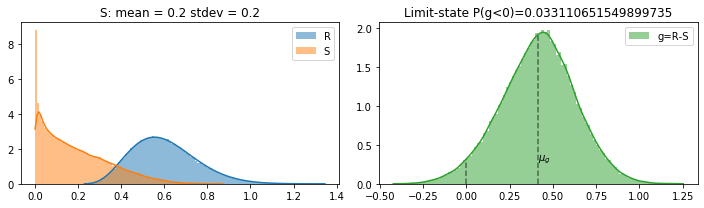

In [404]:
# run model - example at t = 10 years
cl_model = Chloride_Model(cl_pars)
# overwrite C_S_dx and dx
cl_model.pars.C_S_dx = 0.209/cl_pars.cement_concrete_ratio  # 0.209 # cl/concrete %
cl_model.pars.dx = 0  # mm

cl_model.run(x = cover_depth, t = 10)
cl_model.postproc(plot=True)

In [271]:
year_lis_cl = np.arange(1,300,1)
pf_cl, beta_cl = cl_model.chloride_with_year(depth=cover_depth, year_lis=year_lis_cl, amplify = 4, plot=False)
# plt.savefig('plots/chloride_year.pdf', dpi=600)



In [272]:
# put results in a pandas dataframe and save to disk
df_cl = pd.DataFrame({'year': year_lis_cl, 'pf': pf_cl, 'beta': beta_cl})
# df_cl.to_csv("tables/chloride_year_wc04_cem.csv", index=None)

In [273]:
# 0.35 with silica fume
cl_model_SF = cl_model.copy()
cl_model_SF.pars.option.cement_type = 'CEM_I_42.5_R+SF'
cl_model_SF.pars.option.wc_eqv = 0.35
pf_cl_SF, beta_cl_SF = cl_model_SF.chloride_with_year(depth=cover_depth, year_lis=year_lis_cl, amplify = 4, plot=False)
df_cl_SF = pd.DataFrame({'year': year_lis_cl, 'pf': pf_cl_SF, 'beta': beta_cl_SF})
# df_cl_SF.to_csv("tables/chloride_year_wc04_cem_SF.csv", index=None)




# Combined probability of chloride-indueced corrosion at time t

+ Now we have the probability of the onset of chloride diffusion/membrane breakdown, 〖p_f〗_m Then we know the at a given historical time stamp t_i there is chloride diffusion started with a incremental probability of Δ〖p_f〗_(m,t_i ), and for that time portion, it ends up with the chloride diffusion duration of (t - t_i) with a p_(f_(cl,(t-t_i)) ) of chloride reaching limit state. By deviding and wrapping of all the time steps, we have the P_f of chloride-induced corrosion combing both membrane breakdown and chloride diffusion.
+ sudo code

t -> t_list

incremental delta_pf_mem = diff(pf_mem)

1- product 1-delta_pf_mem(@ ti) * pf_chloride (0->ti) for ti in all time step t=[0,1,...ti...t] 




In [274]:
def pf_mem_cl(t, pf_membrane_t_curve, pf_cl_t_curve):
    """
    returns the propagated total probability of membrane failure and chloride-induced corrosion

    input:
    interpolation curves pf_membrane_t_curve = (t_lis, pf_lis), 
    pf_cl_t_curve = (x_loss_array, p_surface_crack_array)
    
    """
    pf_mem_cl_t = []

    t_mem, pf_mem = pf_membrane_t_curve
    t_cl, pf_cl = pf_cl_t_curve

    for ti in t:
        # inspection in this_year ti
        t_lis = t[0 : np.where(t == ti)[0][0] + 1]
        age_lis = ti - t
        age_lis = age_lis[age_lis >= 0]  # positive duration

        # interpolate membrane pf curve
        pf_mem_lis = np.interp(
            age_lis, t_mem, pf_mem, left=pf_mem.min(), right=pf_mem.max()
        )

        # interpolate chloride pf curve
        pf_cl_lis = np.interp(age_lis, t_cl, pf_cl, left=pf_cl.min(), right=pf_cl.max())

        pf_mem_increment = np.diff(pf_mem_lis, prepend=0)
        pf_mem_cl_t.append(1- np.prod((1-pf_cl_lis * pf_mem_increment)))

    return np.array(pf_mem_cl_t)



In [338]:
t = np.arange(0, 300.5, 0.5)
# membrane+chloride w/c=0.4
pf_mem_cl_t = pf_mem_cl(
    t,
    pf_membrane_t_curve=(year_lis, pf_mem),
    pf_cl_t_curve=(year_lis_cl, pf_cl)
)

pf_mem_main_cl_t = pf_mem_cl(
    t,
    pf_membrane_t_curve=(year_lis_main, pf_mem_main),
    pf_cl_t_curve=(year_lis_cl, pf_cl)
)

# membrane + chloride w/c equivalent = 0.35 with silica fume (SF)
pf_mem_cl_t_SF = pf_mem_cl(
    t,
    pf_membrane_t_curve=(year_lis, pf_mem),
    pf_cl_t_curve=(year_lis_cl, pf_cl_SF)
)
pf_mem_main_cl_t_SF = pf_mem_cl(
    t,
    pf_membrane_t_curve=(year_lis_main, pf_mem_main),
    pf_cl_t_curve=(year_lis_cl, pf_cl_SF)
)


df_membrane_and_chloride = pd.DataFrame(
    {'year':t, 
    'membrane': np.interp(t, year_lis, pf_mem, left=pf_mem.min(), right=pf_mem.max()),
    'chloride_wc_0.4': np.interp(t, year_lis_cl, pf_cl, left=pf_cl.min(), right=pf_cl.max()),
    'chloride_wc_0.35_SF': np.interp(t, year_lis_cl, pf_cl_SF, left=pf_cl_SF.min(), right=pf_cl_SF.max()),
    'membrane + chloride_wc_0.4': pf_mem_cl_t,
    'membrane with maintenance + chloride_wc_0.4': pf_mem_main_cl_t,
    'membrane + chloride_wc_0.37_SF': pf_mem_cl_t_SF,
    'membrane with maintenance + chloride_wc_0.37_SF': pf_mem_main_cl_t_SF
    }
    )

df_membrane_and_chloride.to_csv("plots/pf_membrane_and_chloride_plot_data.csv", index=None)



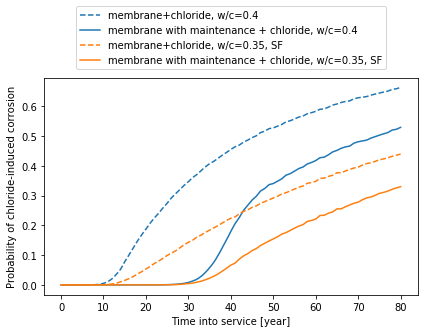

In [331]:
# plot pf together

t_range=(0,80)
mask = df_membrane_and_chloride['year']<= t_range[1]

plt.figure(figsize=(6,5))
plt.plot(
    df_membrane_and_chloride.loc[mask,'year'], 
    df_membrane_and_chloride.loc[mask,'membrane + chloride_wc_0.4'],
    '--',
    color = 'C0',
    label='membrane+chloride, w/c=0.4'
)
plt.plot(
    df_membrane_and_chloride.loc[mask,'year'], 
    df_membrane_and_chloride.loc[mask,'membrane with maintenance + chloride_wc_0.4'],
    color = 'C0',
    label='membrane with maintenance + chloride, w/c=0.4'
)
plt.plot(
    df_membrane_and_chloride.loc[mask,'year'], 
    df_membrane_and_chloride.loc[mask,'membrane + chloride_wc_0.37_SF'],
    '--',
    color = 'C1',
    label='membrane+chloride, w/c=0.35, SF'
)
plt.plot(
    df_membrane_and_chloride.loc[mask,'year'], 
    df_membrane_and_chloride.loc[mask,'membrane with maintenance + chloride_wc_0.37_SF'],
    color = 'C1',
    label='membrane with maintenance + chloride, w/c=0.35, SF'
)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=1, fancybox=True, shadow=False)

plt.xlabel('Time into service [year]')
plt.ylabel('Probability of chloride-induced corrosion')
plt.tight_layout()
plt.savefig('plots/pf_chloride_induced_corrosion_all.pdf', dpi=600)


# cdf to pdf(parametric)

In [375]:

def cdf_curve_to_lognorm_pdf(cdf_x_y, plot= False, savefig=False, fname=''):
    x,y = cdf_x_y
    # smooth cdf
    from scipy.signal import savgol_filter
    yhat = y.copy()
    for i in range(5):
        yhat = savgol_filter(yhat, 15, 3) # window size 5, polynomial order 3

#     # plot cdf
#     plt.plot(x,y,'.')
#     plt.plot(x, yhat,'-')

    
    # fit pdf by function
    from scipy.stats import lognorm
    from scipy.optimize import curve_fit
    def lognorm_pdf(x, s, loc, scale):
        return lognorm.pdf(x, s, loc, scale)

    pdf_data_fit = np.diff(yhat,prepend=0)
    bounds = ([0, x[np.argmax(pdf_data_fit)]*0.9, 0],
              [np.inf, x[np.argmax(pdf_data_fit)]*1.01, np.inf])
    popt, pcov = curve_fit(lognorm_pdf, x, pdf_data_fit, p0=(1, x[np.argmax(pdf_data_fit)], 30), )
    if plot:
        plt.figure()
        plt.plot(x, pdf_data_fit,label='smoothed data')
        plt.plot(x, lognorm_pdf(x, *popt), label='fit')
        plt.xlabel('Time into service [year]')
        plt.ylabel('Distribution density')
        plt.legend()
        plt.title(fname[4:-4])
        plt.tight_layout()
        if savefig:
            plt.savefig('plots/{}'.format(fname), dpi=600)

    shape, loc, scale = popt
    print('mean', scale+loc) # mean of X, scale is mean of X(standard lognormal with loc=0), 
    print('standard deviation', np.e**shape) # standard deviation of X, shape is std of ln(X)
    print('(shape, location, scale) = {}'.format(popt))

    return shape, loc, scale

mean 369.96110616560605
standard deviation 14.04701828104326
(shape, location, scale) = [  2.64241015  17.43524929 352.52585687]


(2.6424101512676783, 17.435249292252802, 352.52585687335323)

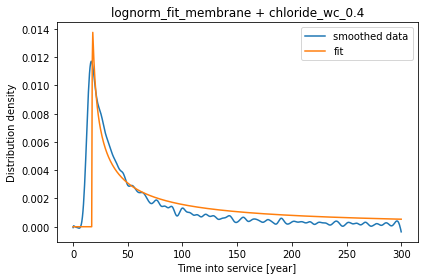

In [376]:
cdf_curve_to_lognorm_pdf(
    cdf_x_y=(df_membrane_and_chloride['year'],
df_membrane_and_chloride['membrane + chloride_wc_0.4']), plot=True, savefig=True, fname = 'pdf_lognorm_fit_membrane + chloride_wc_0.4.pdf')

In [368]:
fname = 'pdf_lognorm_fit_membrane + chloride_wc_0.4.pdf'


[  3.44795922  36.99999909 333.88555852]
mean 370.8855576132741
standard deviation 31.436172537805245


(3.447959221530833, 36.99999908985051, 333.8855585234236)

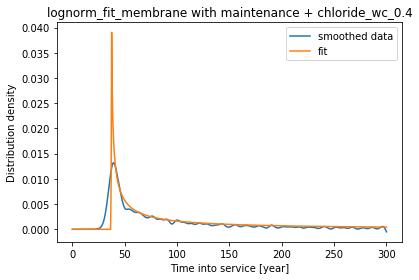

In [372]:
cdf_curve_to_lognorm_pdf(
    cdf_x_y=(df_membrane_and_chloride['year'],
df_membrane_and_chloride['membrane with maintenance + chloride_wc_0.4']), plot=True, savefig=True, fname = 'pdf_lognorm_fit_membrane with maintenance + chloride_wc_0.4.pdf')

[  2.46476752  24.22804733 637.30114   ]
mean 661.5291873312062
standard deviation 11.760747707478025


(2.4647675210171816, 24.228047331795203, 637.301139999411)

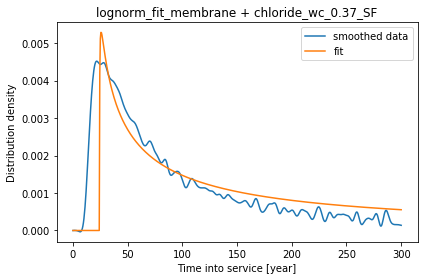

In [370]:
cdf_curve_to_lognorm_pdf(
    cdf_x_y=(df_membrane_and_chloride['year'],
df_membrane_and_chloride['membrane + chloride_wc_0.37_SF']), plot=True, savefig=True, fname = 'pdf_lognorm_fit_membrane + chloride_wc_0.37_SF.pdf')

[  2.57392796  41.52876987 799.67499374]
mean 841.2037636097189
standard deviation 13.117247434742321


(2.5739279623237907, 41.52876987115147, 799.6749937385674)

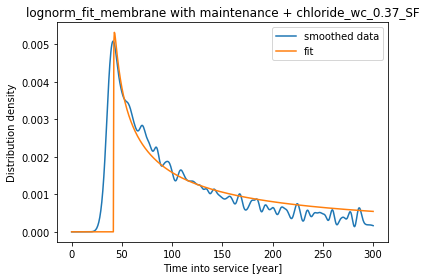

In [371]:
cdf_curve_to_lognorm_pdf(
    cdf_x_y=(df_membrane_and_chloride['year'],
df_membrane_and_chloride['membrane with maintenance + chloride_wc_0.37_SF']), plot=True, savefig=True, fname = 'pdf_lognorm_fit_membrane with maintenance + chloride_wc_0.37_SF.pdf')

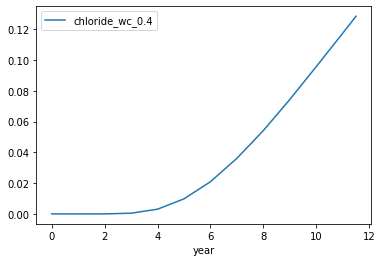

In [389]:
df_membrane_and_chloride[df_membrane_and_chloride['year']<12].plot(x='year', y=df_membrane_and_chloride.columns[2])

In [383]:
df_membrane_and_chloride.columns

Index(['year', 'membrane', 'chloride_wc_0.4', 'chloride_wc_0.35_SF',
       'membrane + chloride_wc_0.4',
       'membrane with maintenance + chloride_wc_0.4',
       'membrane + chloride_wc_0.37_SF',
       'membrane with maintenance + chloride_wc_0.37_SF'],
      dtype='object')

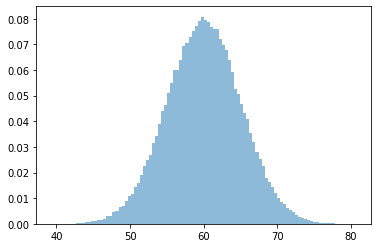

In [393]:
hf.Hist_custom(cover_depth)

In [395]:
cl_model.pars.C_S_dx

1.672